# Hyperband

Impelementation of Hyperband https://arxiv.org/pdf/1603.06560.pdf with ideas from blog post by the same authors https://homes.cs.washington.edu/~jamieson/hyperband.html

In [1]:
%load_ext sql

/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Greenplum Database 5.x on GCP (PM demo machine) - direct external IP access
#%sql postgresql://gpadmin@34.67.65.96:5432/madlib

# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

#psycopg2 connection
import psycopg2 as p2
#conn = p2.connect('postgresql://gpadmin@35.239.240.26:5432/madlib')
#conn = p2.connect('postgresql://fmcquillan@localhost:5432/madlib')
conn = p2.connect('postgresql://gpadmin@localhost:8000/madlib')
cur = conn.cursor()

Pretty print run schedule

In [11]:
import numpy as np
from math import log, ceil

#input
max_iter = 27  # maximum iterations/epochs per configuration
eta = 3  # defines downsampling rate (default=3)

logeta = lambda x: log(x)/log(eta)
s_max = int(logeta(max_iter))  # number of unique executions of Successive Halving (minus one)
B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)

#echo output
print ("max_iter = " + str(max_iter))
print ("eta = " + str(eta))
print ("B = " + str(s_max+1) + "*max_iter = " + str(B))

sum_leaf_n_i = 0 # count configurations at leaf nodes across all s

#### Begin Finite Horizon Hyperband outlerloop. Repeat indefinitely.
for s in reversed(range(s_max+1)):
    
    print (" ")
    print ("s=" + str(s))
    print ("n_i      r_i")
    print ("------------")
    counter = 0
    
    n = int(ceil(int(B/max_iter/(s+1))*eta**s)) # initial number of configurations
    r = max_iter*eta**(-s) # initial number of iterations to run configurations for

    #### Begin Finite Horizon Successive Halving with (n,r)
    #T = [ get_random_hyperparameter_configuration() for i in range(n) ] 
    for i in range(s+1):
        # Run each of the n_i configs for r_i iterations and keep best n_i/eta
        n_i = n*eta**(-i)
        r_i = r*eta**(i)
        
        print (str(n_i) + "     " + str (r_i))
        
        # check if leaf node for this s
        if counter == s:
            sum_leaf_n_i += n_i
        counter += 1
        
        #val_losses = [ run_then_return_val_loss(num_iters=r_i,hyperparameters=t) for t in T ]
        #T = [ T[i] for i in argsort(val_losses)[0:int( n_i/eta )] ]
    #### End Finite Horizon Successive Halving with (n,r)

print (" ")
print ("sum of configurations at leaf nodes across all s = " + str(sum_leaf_n_i))
print ("(if have more workers than this, they may not be 100% busy)")

max_iter = 27
eta = 3
B = 4*max_iter = 108
 
s=3
n_i      r_i
------------
27     1.0
9.0     3.0
3.0     9.0
1.0     27.0
 
s=2
n_i      r_i
------------
9     3.0
3.0     9.0
1.0     27.0
 
s=1
n_i      r_i
------------
6     9.0
2.0     27.0
 
s=0
n_i      r_i
------------
4     27
 
sum of configurations at leaf nodes across all s = 8.0
(if have more workers than this, they may not be 100% busy)


Create tables

In [3]:
%%sql
-- overall results table
DROP TABLE IF EXISTS results;
CREATE TABLE results ( 
                      model_id INTEGER, 
                      compile_params TEXT,
                      fit_params TEXT, 
                      model_type TEXT, 
                      model_size DOUBLE PRECISION, 
                      metrics_elapsed_time DOUBLE PRECISION[], 
                      metrics_type TEXT[], 
                      training_metrics_final DOUBLE PRECISION, 
                      training_loss_final DOUBLE PRECISION, 
                      training_metrics DOUBLE PRECISION[], 
                      training_loss DOUBLE PRECISION[], 
                      validation_metrics_final DOUBLE PRECISION, 
                      validation_loss_final DOUBLE PRECISION, 
                      validation_metrics DOUBLE PRECISION[], 
                      validation_loss DOUBLE PRECISION[], 
                      model_arch_table TEXT, 
                      num_iterations INTEGER, 
                      start_training_time TIMESTAMP, 
                      end_training_time TIMESTAMP,
                      s INTEGER, 
                      n INTEGER, 
                      r INTEGER,
                      run_id SERIAL
                     );

-- model selection table
DROP TABLE IF EXISTS mst_table_hb, mst_table_auto_hb;
CREATE TABLE mst_table_hb (
                           mst_key SERIAL, 
                           model_id INTEGER, 
                           compile_params VARCHAR, 
                           fit_params VARCHAR
                          );

-- model selection summary table
DROP TABLE IF EXISTS mst_table_hb_summary;
CREATE TABLE mst_table_hb_summary (model_arch_table varchar);
INSERT INTO mst_table_hb_summary VALUES ('model_arch_library');

Done.
Done.
Done.
Done.
Done.
Done.
1 rows affected.


[]

Hyperband main 

In [4]:
import numpy as np

from random import random
from math import log, ceil
from time import time, ctime


class Hyperband:
    
    def __init__( self, get_params_function, try_params_function ):
        self.get_params = get_params_function
        self.try_params = try_params_function

        self.max_iter = 3  # maximum iterations per configuration
        self.eta = 3        # defines configuration downsampling rate (default = 3)

        self.logeta = lambda x: log( x ) / log( self.eta )
        self.s_max = int( self.logeta( self.max_iter ))
        self.B = ( self.s_max + 1 ) * self.max_iter

        self.results = []    # list of dicts
        self.counter = 0
        self.best_loss = np.inf
        self.best_counter = -1

    # can be called multiple times
    def run( self, skip_last = 0, dry_run = False ):

        for s in reversed( range( self.s_max + 1 )):
            
            # initial number of configurations
            n = int( ceil( self.B / self.max_iter / ( s + 1 ) * self.eta ** s ))

            # initial number of iterations per config
            r = self.max_iter * self.eta ** ( -s )
            
            print ("s = ", s)
            print ("n = ", n)
            print ("r = ", r)

            # n random configurations
            T = self.get_params(n) # what to return from function if anything?
            
            for i in range(( s + 1 ) - int( skip_last )): # changed from s + 1

                # Run each of the n configs for <iterations>
                # and keep best (n_configs / eta) configurations

                n_configs = n * self.eta ** ( -i )
                n_iterations = r * self.eta ** ( i )

                print "\n*** {} configurations x {:.1f} iterations each".format(
                    n_configs, n_iterations )
                
                # multi-model training
                U = self.try_params(s, n_configs, n_iterations) # what to return from function if anything?

                # select a number of best configurations for the next loop
                # filter out early stops, if any
                # drop from model selection table, model table and info table to keep all in sync
                k = int( n_configs / self.eta)
                
                %sql DELETE FROM iris_multi_model_info WHERE mst_key NOT IN (SELECT mst_key FROM iris_multi_model_info ORDER BY training_loss_final ASC LIMIT $k::INT);
                %sql DELETE FROM iris_multi_model WHERE mst_key NOT IN (SELECT mst_key FROM iris_multi_model_info);
                %sql DELETE FROM mst_table_hb WHERE mst_key NOT IN (SELECT mst_key FROM iris_multi_model_info);

        #return self.results
        
        return

In [5]:
def get_params(n):
    
    from sklearn.model_selection import ParameterSampler
    from scipy.stats.distributions import uniform
    import numpy as np
    
    # model architecture
    model_id = [1, 2]

    # compile params
    # loss function
    loss = ['categorical_crossentropy']
    # optimizer
    optimizer = ['Adam', 'SGD']
    # learning rate (sample on log scale here not in ParameterSampler)
    lr_range = [0.01, 0.1]
    lr = 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]), n)
    # metrics
    metrics = ['accuracy']

    # fit params
    # batch size
    batch_size = [4, 8]
    # epochs
    epochs = [1]

    # create random param list
    param_grid = {
        'model_id': model_id,
        'loss': loss,
        'optimizer': optimizer,
        'lr': lr,
        'metrics': metrics,
        'batch_size': batch_size,
        'epochs': epochs
    }
    param_list = list(ParameterSampler(param_grid, n_iter=n))

    for params in param_list:

        model_id = str(params.get("model_id"))
        compile_params = "$$loss='" + str(params.get("loss")) + "',optimizer='" + str(params.get("optimizer")) + "(lr=" + str(params.get("lr")) + ")',metrics=['" + str(params.get("metrics")) + "']$$" 
        fit_params = "$$batch_size=" + str(params.get("batch_size")) + ",epochs=" + str(params.get("epochs")) + "$$"  
        row_content = "(" + model_id + ", " + compile_params + ", " + fit_params + ");"
        
        %sql INSERT INTO mst_table_hb (model_id, compile_params, fit_params) VALUES $row_content
    
    return

In [6]:
def try_params(s, n_configs, n_iterations):

    # multi-model fit
    # TO DO:  use warm start to continue from where left off after if not 1st time thru for this s value
    %sql DROP TABLE IF EXISTS iris_multi_model, iris_multi_model_summary, iris_multi_model_info;
    %sql SELECT madlib.madlib_keras_fit_multiple_model('iris_train_packed', 'iris_multi_model', 'mst_table_hb', $n_iterations::INT, 0);
   
    # save results
    %sql DROP TABLE IF EXISTS temp_results;
    %sql CREATE TABLE temp_results AS (SELECT * FROM iris_multi_model_info);
    %sql ALTER TABLE temp_results DROP COLUMN mst_key, ADD COLUMN model_arch_table TEXT, ADD COLUMN num_iterations INTEGER, ADD COLUMN start_training_time TIMESTAMP, ADD COLUMN end_training_time TIMESTAMP, ADD COLUMN s INTEGER, ADD COLUMN n INTEGER, ADD COLUMN r INTEGER;
    %sql UPDATE temp_results SET model_arch_table = (SELECT model_arch_table FROM iris_multi_model_summary), num_iterations = (SELECT num_iterations FROM iris_multi_model_summary), start_training_time = (SELECT start_training_time FROM iris_multi_model_summary), end_training_time = (SELECT end_training_time FROM iris_multi_model_summary), s = $s, n = $n_configs, r = $n_iterations;
    %sql INSERT INTO results (SELECT * FROM temp_results);

    return

In [7]:
hp = Hyperband( get_params, try_params )
results = hp.run()

('s = ', 1)
('n = ', 3)
('r = ', 1.0)
1 rows affected.
1 rows affected.
1 rows affected.

*** 3 configurations x 1.0 iterations each
Done.
1 rows affected.
Done.
3 rows affected.
Done.
3 rows affected.
3 rows affected.
2 rows affected.
2 rows affected.
2 rows affected.

*** 1.0 configurations x 3.0 iterations each
Done.
1 rows affected.
Done.
1 rows affected.
Done.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
('s = ', 0)
('n = ', 2)
('r = ', 3)
1 rows affected.
1 rows affected.

*** 2 configurations x 3.0 iterations each
Done.
1 rows affected.
Done.
2 rows affected.
Done.
2 rows affected.
2 rows affected.
2 rows affected.
2 rows affected.
2 rows affected.


Plot results

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_colwidth', -1)

0 rows affected.


<IPython.core.display.Javascript object>


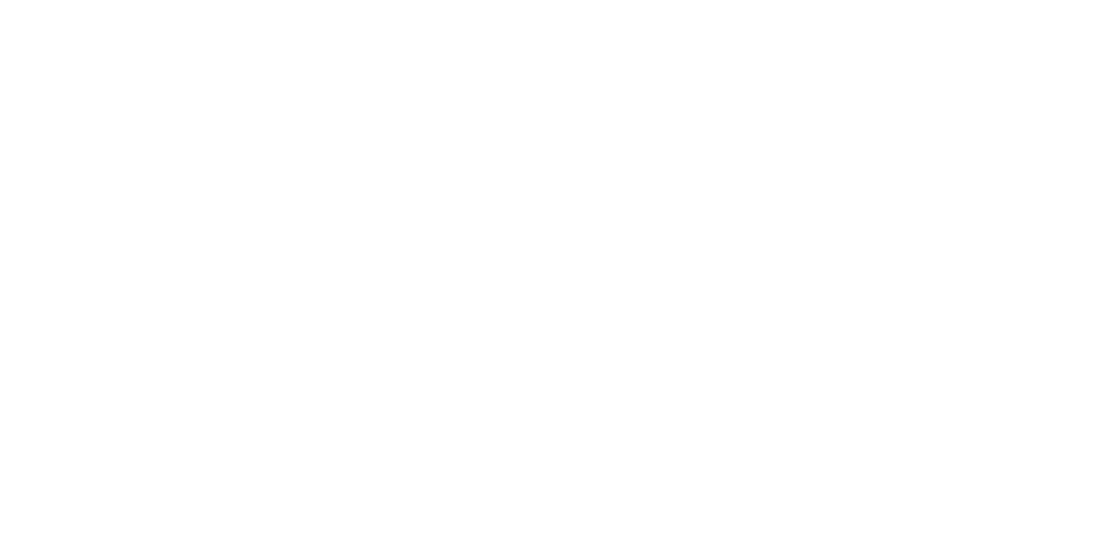

KeyError: 'run_id'

In [9]:
output_root_name = 'results'
df_results = %sql SELECT * FROM $output_root_name ORDER BY run_id;
df_results = df_results.DataFrame()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for run_id in df_results['run_id']:
    df_output_info = %sql SELECT training_metrics,training_loss FROM $output_root_name WHERE run_id = $run_id
    df_output_info = df_output_info.DataFrame()
    training_metrics = df_output_info['training_metrics'][0]
    training_loss = df_output_info['training_loss'][0]
    X = range(len(training_metrics))
    
    ax_metric = axs[0]
    ax_loss = axs[1]
    ax_metric.set_xticks(X[::1])
    ax_metric.plot(X, training_metrics, label=run_id)
    ax_metric.set_xlabel('Iteration')
    ax_metric.set_ylabel('Metric')
    ax_metric.set_title('Training metric curve')

    ax_loss.set_xticks(X[::1])
    ax_loss.plot(X, training_loss, label=run_id)
    ax_loss.set_xlabel('Iteration')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Training loss curve')
    
fig.legend(ncol=4)
fig.tight_layout()
# fig.savefig('./lc_keras_fit.png', dpi = 300)

# ------------------ Scratch ---------------------

In [ ]:
best_configs = %sql SELECT ARRAY(SELECT mst_key FROM iris_multi_model_info ORDER BY training_loss_final ASC LIMIT $k::INT);
                %sql DELETE FROM mst_table_hb WHERE mst_key NOT IN $best_configs;
                %sql DELETE FROM iris_multi_model WHERE mst_key NOT IN $best_configs;
                %sql DELETE FROM iris_multi_model_info WHERE mst_key NOT IN $best_configs;

In [7]:
#!/usr/bin/env python

"bare-bones demonstration of using hyperband to tune sklearn GBT"

#from hyperband import Hyperband
#from defs.gb import get_params, try_params

hb = Hyperband( get_params, try_params )

# no actual tuning, doesn't call try_params()
results = hb.run( dry_run = True )

#results = hb.run( skip_last = 1 ) # shorter run
#results = hb.run()

('s = ', 4)
('n = ', 81)
('r = ', 1.0)

*** 81 configurations x 1.0 iterations each

1 | Mon Nov  4 11:31:06 2019 | lowest loss so far: inf (run -1)


0 seconds.

2 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.8345 (run 1)


0 seconds.

3 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.6510 (run 2)


0 seconds.

4 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.0176 (run 3)


0 seconds.

5 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.0176 (run 3)


0 seconds.

6 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.0176 (run 3)


0 seconds.

7 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.0176 (run 3)


0 seconds.

8 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.0176 (run 3)


0 seconds.

9 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.0176 (run 3)


0 seconds.

10 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.0176 (run 3)


0 seconds.

11 | Mon Nov  4 11:31:06 2019 | lowest loss so far: 0.0176 (run 3)


0 seconds.

12 | Mon Nov  4 11:31:06 2019 | low

In [21]:
best_configs

[([5],)]

In [118]:
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import expon, uniform, lognorm
import numpy as np
#rng = np.random.RandomState()
param_grid = {'a':[1, 2], 'b': expon(), 'c': uniform()}
#param_list = list(ParameterSampler(param_grid, n_iter=5, random_state=rng))
param_list = list(ParameterSampler(param_grid, n_iter=5))
rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items()) for d in param_list]
param_list

[{'a': 2, 'b': 0.3388081749546307, 'c': 0.704635960884642},
 {'a': 1, 'b': 0.4904175136129263, 'c': 0.8971084273807718},
 {'a': 1, 'b': 1.2386463990117793, 'c': 0.21568311690580266},
 {'a': 1, 'b': 1.91007461806631, 'c': 0.17778124867596956},
 {'a': 1, 'b': 1.2563450220231427, 'c': 0.002076412746974121}]

In [33]:
param_list

[{'a': 2, 'b': 0.37954129345633403, 'c': 0.3742154014629032},
 {'a': 2, 'b': 1.2830633021262747, 'c': 0.4373122879029032},
 {'a': 1, 'b': 0.22037072550727527, 'c': 0.26397341600176616},
 {'a': 1, 'b': 0.549444485603122, 'c': 0.8317686948528791},
 {'a': 1, 'b': 1.0567787144413414, 'c': 0.9560841093558743}]

In [34]:
rounded_list

[{'a': 2.0, 'b': 0.379541, 'c': 0.374215},
 {'a': 2.0, 'b': 1.283063, 'c': 0.437312},
 {'a': 1.0, 'b': 0.220371, 'c': 0.263973},
 {'a': 1.0, 'b': 0.549444, 'c': 0.831769},
 {'a': 1.0, 'b': 1.056779, 'c': 0.956084}]

In [150]:
#rng = np.random.RandomState(0)
param_grid = {'d': lognorm(1, 2, 3)}
#param_list = list(ParameterSampler(param_grid, n_iter=5, random_state=rng))
param_list = list(ParameterSampler(param_grid, n_iter=5))
param_list

[{'d': 2.9713720038716116},
 {'d': 10.275052606706604},
 {'d': 4.211836333907813},
 {'d': 3.6005371688499834},
 {'d': 14.68709362771547}]

In [197]:
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import uniform
import numpy as np

#s = np.random.uniform(-1,1,7)
#print (s)
   
# optimizer
optimizer = ['Adam', 'SGD']
# learning rate (log scale)
lr_range = [0.001, 10]
lr = 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]), 7)
print (lr)

# create random param list
param_grid = {
        'optimizer': optimizer,
        'lr': lr
}
param_list = list(ParameterSampler(param_grid, n_iter=7))
param_list

[0.20984381 1.42136262 0.81160104 0.038913   0.22006219 6.32888505
 0.09113144]


[{'lr': 0.22006218937865862, 'optimizer': 'Adam'},
 {'lr': 1.4213626223774578, 'optimizer': 'SGD'},
 {'lr': 0.09113143553155685, 'optimizer': 'SGD'},
 {'lr': 0.09113143553155685, 'optimizer': 'Adam'},
 {'lr': 0.038913004274499154, 'optimizer': 'Adam'},
 {'lr': 0.038913004274499154, 'optimizer': 'SGD'},
 {'lr': 6.328885051196006, 'optimizer': 'Adam'}]

In [266]:
# model architecture
model_id = [1, 2]

# compile params

# loss function
loss = ['categorical_crossentropy']
# optimizer
optimizer = ['Adam', 'SGD']
# learning rate
lr = [0.01, 0.1]
# metrics
metrics = ['accuracy']

# fit params

# batch size
batch_size = [4, 8]
# epochs
epochs = [1]

# create random param list
param_grid = {
    'model_id': model_id,
    'loss': loss,
    'optimizer': optimizer,
    'lr': uniform(lr[0], lr[1]),
    'metrics': metrics,
    'batch_size': batch_size,
    'epochs': epochs
}
param_list = list(ParameterSampler(param_grid, n_iter=10))
param_list

[{'batch_size': 8,
  'epochs': 1,
  'loss': 'categorical_crossentropy',
  'lr': 0.07983433464722507,
  'metrics': 'accuracy',
  'model_id': 2,
  'optimizer': 'Adam'},
 {'batch_size': 4,
  'epochs': 1,
  'loss': 'categorical_crossentropy',
  'lr': 0.03805362658279962,
  'metrics': 'accuracy',
  'model_id': 1,
  'optimizer': 'SGD'},
 {'batch_size': 4,
  'epochs': 1,
  'loss': 'categorical_crossentropy',
  'lr': 0.09043633721868387,
  'metrics': 'accuracy',
  'model_id': 2,
  'optimizer': 'Adam'},
 {'batch_size': 8,
  'epochs': 1,
  'loss': 'categorical_crossentropy',
  'lr': 0.02775811670911417,
  'metrics': 'accuracy',
  'model_id': 1,
  'optimizer': 'Adam'},
 {'batch_size': 8,
  'epochs': 1,
  'loss': 'categorical_crossentropy',
  'lr': 0.104019113296403,
  'metrics': 'accuracy',
  'model_id': 2,
  'optimizer': 'Adam'},
 {'batch_size': 8,
  'epochs': 1,
  'loss': 'categorical_crossentropy',
  'lr': 0.06986494800074812,
  'metrics': 'accuracy',
  'model_id': 2,
  'optimizer': 'SGD'},
 {

In [212]:
param_list[0]

{'batch_size': 8,
 'epochs': 1,
 'loss': 'categorical_crossentropy',
 'lr': 0.03396784466820144,
 'optimizer': 'Adam'}

In [285]:
for params in param_list:
#    for key, value in params.items():
#        print (key, value)

    compile_params = "$$loss='" + str(params.get("loss")) + "',optimizer='" + str(params.get("optimizer")) + "(lr=" + str(params.get("lr")) + ")',metrics=['" + str(params.get("metrics")) + "']$$" 
    print (compile_params)
        
    fit_params = "batch_size=" + str(params.get("batch_size")) + ",epochs=" + str(params.get("epochs"))
    print (fit_params)

$$loss='categorical_crossentropy',optimizer='Adam(lr=0.07983433464722507)',metrics=['accuracy']$$
batch_size=8,epochs=1
$$loss='categorical_crossentropy',optimizer='SGD(lr=0.03805362658279962)',metrics=['accuracy']$$
batch_size=4,epochs=1
$$loss='categorical_crossentropy',optimizer='Adam(lr=0.09043633721868387)',metrics=['accuracy']$$
batch_size=4,epochs=1
$$loss='categorical_crossentropy',optimizer='Adam(lr=0.02775811670911417)',metrics=['accuracy']$$
batch_size=8,epochs=1
$$loss='categorical_crossentropy',optimizer='Adam(lr=0.104019113296403)',metrics=['accuracy']$$
batch_size=8,epochs=1
$$loss='categorical_crossentropy',optimizer='SGD(lr=0.06986494800074812)',metrics=['accuracy']$$
batch_size=8,epochs=1
$$loss='categorical_crossentropy',optimizer='Adam(lr=0.010449656955883938)',metrics=['accuracy']$$
batch_size=4,epochs=1
$$loss='categorical_crossentropy',optimizer='SGD(lr=0.04915490422264339)',metrics=['accuracy']$$
batch_size=4,epochs=1
$$loss='categorical_crossentropy',optimizer=

In [301]:
%sql DROP TABLE IF EXISTS mst_table_hb, mst_table_auto_hb;

%sql CREATE TABLE mst_table_hb(mst_key serial, model_id integer, compile_params varchar, fit_params varchar);

for params in param_list:
    model_id = str(params.get("model_id"))
    compile_params = "$$loss='" + str(params.get("loss")) + "',optimizer='" + str(params.get("optimizer")) + "(lr=" + str(params.get("lr")) + ")',metrics=['" + str(params.get("metrics")) + "']$$" 
    fit_params = "$$batch_size=" + str(params.get("batch_size")) + ",epochs=" + str(params.get("epochs")) + "$$"  
    row_content = "(" + model_id + ", " + compile_params + ", " + fit_params + ");"
    
    %sql INSERT INTO mst_table_hb (model_id, compile_params, fit_params) VALUES $row_content

Done.
Done.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [302]:
%%sql
SELECT * FROM mst_table_hb ORDER BY mst_key;

10 rows affected.


[(1, 2, u"loss='categorical_crossentropy',optimizer='Adam(lr=0.07983433464722507)',metrics=['accuracy']", u'batch_size=8,epochs=1'),
 (2, 1, u"loss='categorical_crossentropy',optimizer='SGD(lr=0.03805362658279962)',metrics=['accuracy']", u'batch_size=4,epochs=1'),
 (3, 2, u"loss='categorical_crossentropy',optimizer='Adam(lr=0.09043633721868387)',metrics=['accuracy']", u'batch_size=4,epochs=1'),
 (4, 1, u"loss='categorical_crossentropy',optimizer='Adam(lr=0.02775811670911417)',metrics=['accuracy']", u'batch_size=8,epochs=1'),
 (5, 2, u"loss='categorical_crossentropy',optimizer='Adam(lr=0.104019113296403)',metrics=['accuracy']", u'batch_size=8,epochs=1'),
 (6, 2, u"loss='categorical_crossentropy',optimizer='SGD(lr=0.06986494800074812)',metrics=['accuracy']", u'batch_size=8,epochs=1'),
 (7, 2, u"loss='categorical_crossentropy',optimizer='Adam(lr=0.010449656955883938)',metrics=['accuracy']", u'batch_size=4,epochs=1'),
 (8, 2, u"loss='categorical_crossentropy',optimizer='SGD(lr=0.04915490422264339)',metrics=['accuracy']", u'batch_size=4,epochs=1'),
 (9, 1, u"loss='categorical_crossentropy',optimizer='Adam(lr=0.05257644929029893)',metrics=['accuracy']", u'batch_size=8,epochs=1'),
 (10, 2, u"loss='categorical_crossentropy',optimizer='SGD(lr=0.02993608422766151)',metrics=['accuracy']", u'batch_size=8,epochs=1')]

In [ ]:
import numpy as np

from random import random
from math import log, ceil
from time import time, ctime


class Hyperband:
    
    def __init__( self, get_params_function, try_params_function ):
        self.get_params = get_params_function
        self.try_params = try_params_function

        self.max_iter = 81  # maximum iterations per configuration
        self.eta = 3        # defines configuration downsampling rate (default = 3)

        self.logeta = lambda x: log( x ) / log( self.eta )
        self.s_max = int( self.logeta( self.max_iter ))
        self.B = ( self.s_max + 1 ) * self.max_iter

        self.results = []    # list of dicts
        self.counter = 0
        self.best_loss = np.inf
        self.best_counter = -1


    # can be called multiple times
    def run( self, skip_last = 0, dry_run = False ):

        for s in reversed( range( self.s_max + 1 )):
            
            # initial number of configurations
            n = int( ceil( self.B / self.max_iter / ( s + 1 ) * self.eta ** s ))

            # initial number of iterations per config
            r = self.max_iter * self.eta ** ( -s )
            
            print ("s = ", s)
            print ("n = ", n)
            print ("r = ", r)

            # n random configurations
            T = self.get_params(n) # what to return from function if anything?
            
            return

            for i in range(( s + 1 ) - int( skip_last )): # changed from s + 1

                # Run each of the n configs for <iterations>
                # and keep best (n_configs / eta) configurations

                n_configs = n * self.eta ** ( -i )
                n_iterations = r * self.eta ** ( i )

                print "\n*** {} configurations x {:.1f} iterations each".format(
                    n_configs, n_iterations )

                val_losses = []
                early_stops = []
                
                
                
                

                for t in T:

                    self.counter += 1
                    print "\n{} | {} | lowest loss so far: {:.4f} (run {})\n".format(
                        self.counter, ctime(), self.best_loss, self.best_counter )

                    start_time = time()

                    if dry_run:
                        result = { 'loss': random(), 'log_loss': random(), 'auc': random()}
                    else:
                        result = self.try_params( n_iterations, t )  # <---

                    assert( type( result ) == dict )
                    assert( 'loss' in result )

                    seconds = int( round( time() - start_time ))
                    print "\n{} seconds.".format( seconds )

                    loss = result['loss']
                    val_losses.append( loss )

                    early_stop = result.get( 'early_stop', False )
                    early_stops.append( early_stop )

                    # keeping track of the best result so far (for display only)
                    # could do it be checking results each time, but hey
                    if loss < self.best_loss:
                        self.best_loss = loss
                        self.best_counter = self.counter

                    result['counter'] = self.counter
                    result['seconds'] = seconds
                    result['params'] = t
                    result['iterations'] = n_iterations
                        
                    self.results.append( result )

                # select a number of best configurations for the next loop
                # filter out early stops, if any
                indices = np.argsort( val_losses )
                T = [ T[i] for i in indices if not early_stops[i]]
                T = T[ 0:int( n_configs / self.eta )]
                        
        return self.results